## Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam
import math
from matplotlib import pyplot as plt
import numpy as np

2024-03-11 09:42:24.713153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Creación del Modelo para resolver la ecuación diferencial

# $$xy'+y-x^{2}cos(x)=0$$ con la condición $$y(0)=0$$

In [2]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy+y_pred -tf.math.cos(x)*x**2 #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación del modelo

In [3]:
model = ODEsolver()
model.add(Dense(200, activation='tanh', input_shape=(1,)))
model.add(Dense(400, activation='tanh'))
model.add(Dense(250, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))
model.summary()

2024-03-11 09:42:42.269102: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "od_esolver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               400       
                                                                 
 dense_1 (Dense)             (None, 400)               80400     
                                                                 
 dense_2 (Dense)             (None, 250)               100250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 181,303
Trainable params: 181,303
Non-trainable params: 0
_________________________________________________________________


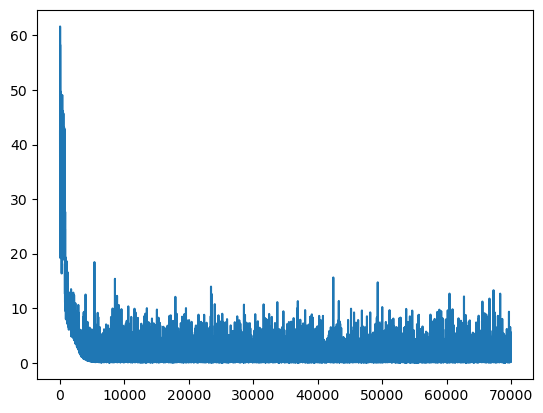

In [4]:
model.compile(Adam(learning_rate=0.001),metrics=['loss'])
x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=70000,verbose=0)
plt.plot(history.history["loss"])

# Graficando la solución

4/4 [==============================] - 0s 4ms/step


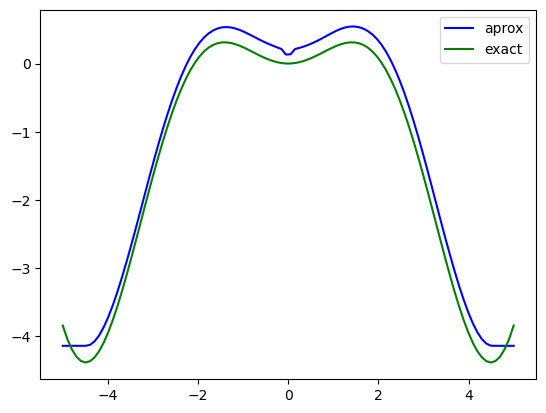

In [5]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox", color='blue')
plt.plot(x_testv,x*tf.math.sin(x) + 2.*tf.math.cos(x) - 2.*tf.math.sin(x)/x,label="exact", color='green')
plt.legend()
plt.show()